**To begin with we install our yfinance library and import some other libraries to help us out**

In [4]:
!pip install yfinance
!pip install ipywidgets
!pip install voila
!pip install keras
!pip install tensorflow
!pip install ipywidgets
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from datetime import date
from datetime import timedelta

  Using cached tensorflow-2.6.0-cp38-cp38-win_amd64.whl (423.2 MB)
  Using cached absl_py-0.15.0-py3-none-any.whl (132 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached clang-5.0-py3-none-any.whl
  Using cached h5py-3.1.0-cp38-cp38-win_amd64.whl (2.7 MB)
  Using cached tensorboard-2.7.0-py3-none-any.whl (5.8 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached grpcio-1.41.0-cp38-cp38-win_amd64.whl (3.2 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached tensorflow_estimator-2.6.0-py2.py3-none-any.whl (462 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached Markdown-3.3.4-py3-none-any.whl (97 kB)
  Attempting uninstall: h5py
    Found existing i

**Next we're going to download the historic data for SPY. You can change the beginning year using the slider**

In [5]:

slider=widgets.IntSlider(min=2000, max=2020, step=1, value = 2010)
display(slider)

IntSlider(value=2010, max=2020, min=2000)

In [6]:
sp5 = yf.Ticker("SPY")
history = sp5.history(start=str(slider.value) + "-01-01", end = date.today().strftime("%Y-%m-%d"))#end="2021-01-01")


**Here is a histogram of the full dataset.**

<class 'pandas.core.series.Series'>


<AxesSubplot:xlabel='Date'>

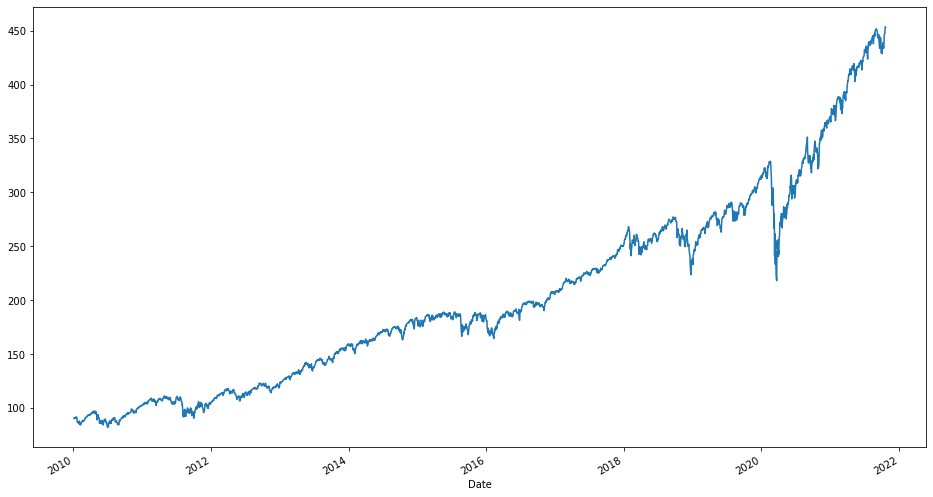

In [7]:
data = history['Close']
print(type(data))
data.plot(figsize=(16,9))

**Next we'll clean the data then we'll extract the training data.**

In [8]:
data = history.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset) *.8)

training_data_len 

2379

**Here we're going to scale the data to be between 0 and 1. This works beter when training the model.**

In [9]:
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.02189736],
       [0.02254015],
       [0.02271146],
       ...,
       [0.99682388],
       [1.        ],
       [0.99873492]])

**Here we're going goin to put the data into sets for the training model. Below is an example of a training set.**

In [10]:
slider_training_len=widgets.IntSlider(min=10, max=120, step=10, value = 10)
display(slider_training_len)

IntSlider(value=10, max=120, min=10, step=10)

In [11]:
train_data = scaled_data[0: training_data_len, :]
x_train = []
y_train = []
input_data_length = slider_training_len.value
print(input_data_length)
print(len(train_data))
for i in range(input_data_length, len(train_data)):
  x_train.append(train_data[i-input_data_length:i, 0])
  y_train.append(train_data[i,0])
  if i <= input_data_length:
    print(x_train)
    print(y_train)
    print()

10
2379
[array([0.02189736, 0.02254015, 0.02271146, 0.02373988, 0.02455397,
       0.02489671, 0.0226044 , 0.02466111, 0.02532525, 0.02256153])]
[0.02560379406006763]



**Here we change the input data to numpy arrays and change the x training data to a 3 dimentional array for the training model.**

In [12]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))


**This is where we initialize the model.**

In [13]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(x_train.shape[1],1)))
#model.add(Dropout(.3))
model.add(LSTM(64, return_sequences=False))
#model.add(Dropout(.3))
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

**Here we're going to train the model. This may take a few minutes.**

In [14]:
model.fit(x_train,y_train,batch_size=64, epochs=5)

Epoch 1/5
38/38 [==============================] - 2s 6ms/step - loss: 0.0102
Epoch 2/5
38/38 [==============================] - 0s 5ms/step - loss: 2.1908e-04
Epoch 3/5
38/38 [==============================] - 0s 5ms/step - loss: 7.3890e-05
Epoch 4/5
38/38 [==============================] - 0s 5ms/step - loss: 6.6316e-05
Epoch 5/5
38/38 [==============================] - 0s 5ms/step - loss: 6.5887e-05


**Here we build the dataset that we're going to make our predictions off of.**

In [15]:
test_data = scaled_data[training_data_len-input_data_length: , :]
x_test = []
y_test = dataset[training_data_len: , : ]
for i in range(input_data_length,len(test_data)):
  x_test.append(test_data[i-input_data_length:i,0])

**Next we reshape the data so that it can be input into the model**

In [16]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

**And Finally we make our predictions**

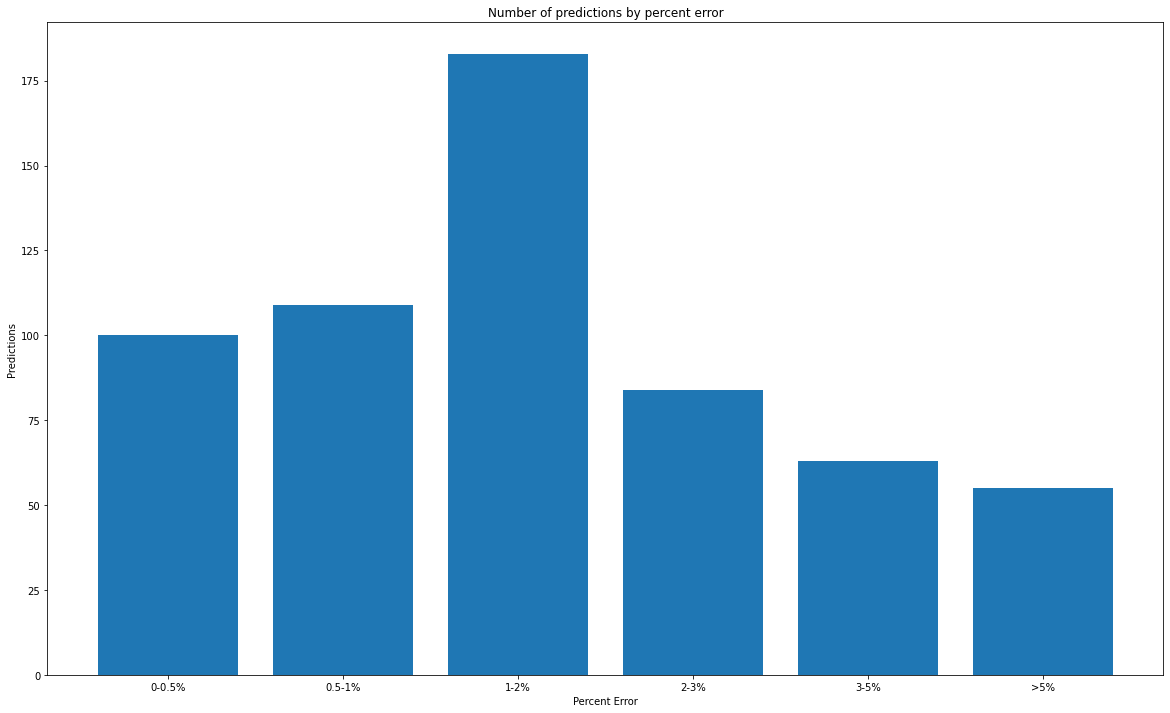

In [17]:
predictions = model.predict(x_test)
x = ['0-0.5%', '0.5-1%', '1-2%', '2-3%', '3-5%', '>5%']
percentage = [0,0,0,0,0,0]
for i in range(input_data_length,len(test_data)):
  if np.absolute(predictions[i - input_data_length]-test_data[i]) / test_data[i] * 100 < .5:
    percentage[0] += 1
  elif np.absolute(predictions[i - input_data_length]-test_data[i]) / test_data[i] * 100 < 1:
    percentage[1] += 1
  elif np.absolute(predictions[i - input_data_length]-test_data[i]) / test_data[i] * 100 < 2:
    percentage[2] += 1
  elif np.absolute(predictions[i - input_data_length]-test_data[i]) / test_data[i] * 100 < 3:
    percentage[3] += 1
  elif np.absolute(predictions[i - input_data_length]-test_data[i]) / test_data[i] * 100 < 5:
    percentage[4] += 1
  else:
    percentage[5] += 1
#print(percentage)
predictions = scaler.inverse_transform(predictions)
#print(predictions)

plt.figure(figsize=(20,12))
plt.bar(x, percentage)
plt.xlabel('Percent Error')
plt.ylabel('Predictions')
plt.title('Number of predictions by percent error')

plt.show()


**Here we check the acurracy using Root Mean Square Error**

In [18]:
rmse = np.sqrt(np.mean(predictions - y_test) **2)
rmse

0.5240189523407908

**Here is a graph showing the predictions**

<ipython-input-19-30ec5f968291>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


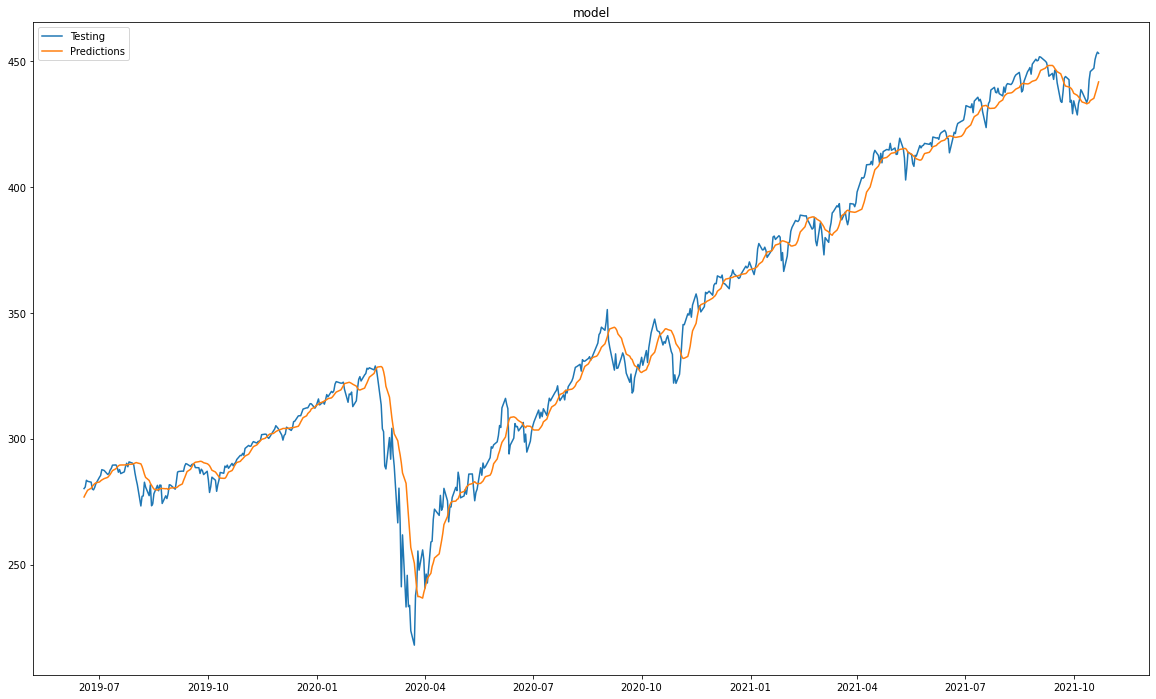

In [19]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(20,12))
plt.title('model')
plt.xlabel('')
plt.ylabel('')
#plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Testing', 'Predictions'])

**Here we will atempt to predict prices for 5 days after the specified date**

In [20]:
test_data = scaled_data[training_data_len-input_data_length: , :]
x_test = []
y_test = dataset[training_data_len: , : ]

In [21]:
slider_date=widgets.SelectionSlider(options=data['Close'][training_data_len:len(data)].keys())
display(slider_date)

SelectionSlider(options=(Timestamp('2019-06-18 00:00:00'), Timestamp('2019-06-19 00:00:00'), Timestamp('2019-0…

C:\Users\joe_b\anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
<ipython-input-23-74c4ec8e42b6>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid2['Predictions'] = predictions5d['Close']


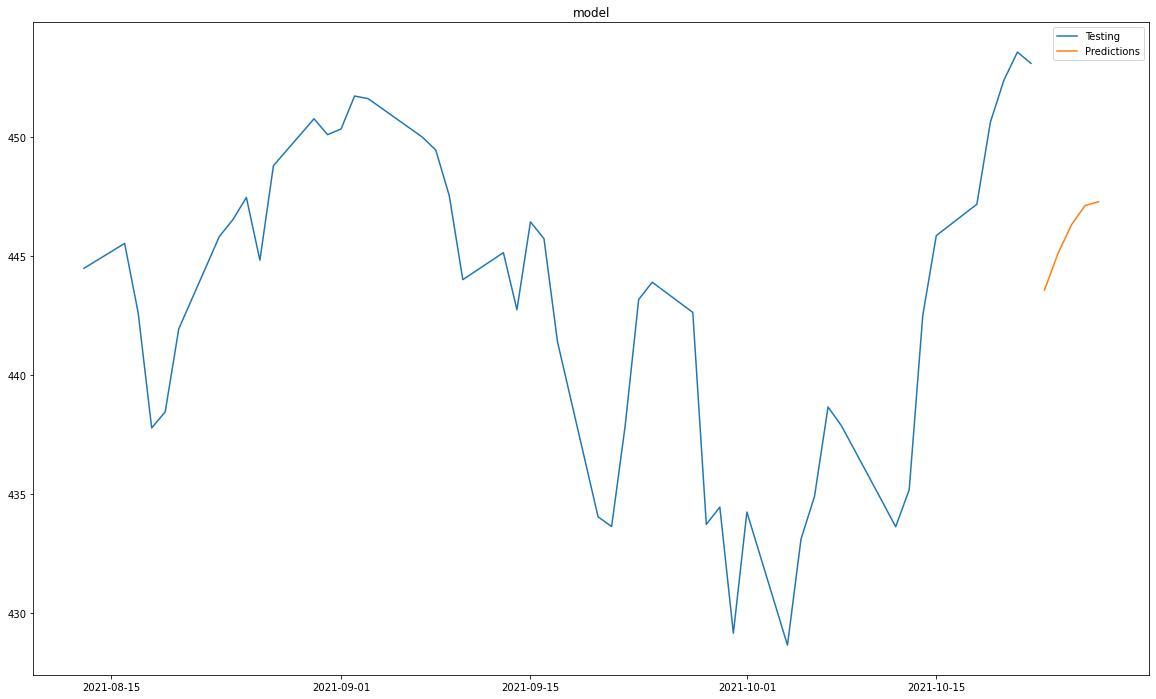

In [23]:
#set up predictions with dates
predictions5d = data[training_data_len:].copy()
prediction = []

#removes data from predictions leaving dates
for i in range(0,predictions5d.size):
  predictions5d['Close'][i] = None

start_pos = input_data_length + slider_date.index + 1
stop_pos = input_data_length + slider_date.index + 6
x_test =[]
x_test.append(test_data[start_pos - input_data_length:start_pos,0])

for i in range(input_data_length + slider_date.index + 1,input_data_length + slider_date.index + 6):
  x_test_data = x_test.copy()
  x_test_data = np.array(x_test_data)
  x_test_data = np.reshape(x_test_data, (x_test_data.shape[0], x_test_data.shape[1], 1))
  prediction.append(model.predict(x_test_data)[0])
  x_test[0] = x_test[0][1:]
  x_test[0] = np.append(x_test[0], model.predict(x_test_data)[0])

valid2 = data[training_data_len + start_pos - 50 - input_data_length:training_data_len + stop_pos - input_data_length]
prediction = scaler.inverse_transform(prediction)
for i in range(slider_date.index + 1,slider_date.index + 6):
  if(i>=predictions5d.size):
    predictions5d.loc[pd.to_datetime(predictions5d.index[i-1]) + timedelta(days=1)]= [None]
    valid2.loc[pd.to_datetime(predictions5d.index[i-1]) + timedelta(days=1)] = [None]
  predictions5d['Close'][i]=prediction[i-slider_date.index -1]


valid2['Predictions'] = predictions5d['Close']
plt.figure(figsize=(20,12))
plt.title('model')
plt.xlabel('')
plt.ylabel('')
plt.plot(valid2[['Close','Predictions']])
plt.legend(['Testing', 'Predictions'])